# Wrangling III 

In this tutorial, we'll round out our focus on data wrangling by looking 

- handling duplicate values
- data transformations
- the `apply()` method
- filtering data


## Preliminaries

As usual, we'll load some libraries we'll be likely to use.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Now we'll get set up to work by

- loading the data and cleaning it up (as before)
- trim out some columns so we can look at the data frame more easily
- shorten up some of the column names to save ourselves some typing

Use our function to do the loading and cleaning.

In [2]:
def bcd_load_clean():
    bcd = pd.read_csv('./data/breast_cancer_data.csv')
    bcd['patient_id'] = bcd['patient_id'].astype('string')
    bcd['doctor_name'] = bcd['doctor_name'].str.split().str[1]
    bcd['bare_nuclei'] = bcd['bare_nuclei'].replace('?', '')
    bcd['bare_nuclei'] = pd.to_numeric(bcd['bare_nuclei'])
    
    return bcd

In [3]:
bcd = bcd_load_clean()

Make a little version with just two numeric columns to play with.

In [4]:
bcd2 = bcd[['patient_id', 'clump_thickness', 'bland_chromatin', 'class']].copy()

Let's give the columns shorter names to save some typing.

In [5]:
bcd2 = bcd2.rename(columns={'clump_thickness': 'thick',
                            'bland_chromatin': 'chrom',
                            'patient_id': 'id'})

## Duplicate entries

As we have already seen, datasets can contain strange things that we have to overcome prior to analysis. One of the most common issues in a dataset are duplicate entries. These are common with large datasets that have been transcribed by humans at some point. Humands get bored, lose their place, etc.

---

Let's look at the shape of our cancer data frame.

In [6]:
bcd2.shape

(699, 4)

---

Now let's look at the number of unique entries using the `nunique()` data frame method; this will the number of distinct values in each column.

In [7]:
bcd2.nunique()

id       645
thick     10
chrom     10
class      2
dtype: int64

---

So we can see that, while there are 699 observations in our data, there are only 645 unique patient ids. This tells us that several patients have multiple entries. This could be from patients making multiple visits to the doctor, or it could be a mistake.

We can find out which rows – which entire observations – are identical with the `duplicated()` method. 

In [8]:
bcd2.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
694    False
695    False
696    False
697    False
698     True
Length: 699, dtype: bool

That's not terribly helpful by itself, but...

---

In the cell below, count the number of duplicated rows (remember a True is a 1).

In [9]:
bcd2.duplicated().sum()

12

---

Now we can use logical indexing to see the observations that have duplicates. Do that in the cell below.

In [10]:
bcd2[bcd2.duplicated()]

id  thick  chrom      class
208  1218860    1.0    3.0     benign
253  1100524    6.0    7.0  malignant
254  1116116    9.0    3.0  malignant
258  1198641    3.0    3.0     benign
272   320675    3.0    7.0  malignant
322   733639    3.0    3.0     benign
338   704097    1.0    2.0     benign
443   734111    1.0    1.0     benign
561  1321942    5.0    3.0     benign
684   466906    1.0    1.0     benign
690   654546    1.0    1.0     benign
698   897471    4.0   10.0  malignant

---

This is promising but, if we look at what is listed, we don't actually see any duplicates. So what is `duplicates()` doing?

---

Use the cell below to get help on `duplicated()` using `help()` or `?`.

In [11]:
help(bcd2.duplicated)

Help on method duplicated in module pandas.core.frame:

duplicated(subset: 'Hashable | Sequence[Hashable] | None' = None, keep: "Literal[('first', 'last', False)]" = 'first') -> 'Series' method of pandas.core.frame.DataFrame instance
    Return boolean Series denoting duplicate rows.
    
    Considering certain columns is optional.
    
    Parameters
    ----------
    subset : column label or sequence of labels, optional
        Only consider certain columns for identifying duplicates, by
        default use all of the columns.
    keep : {'first', 'last', False}, default 'first'
        Determines which duplicates (if any) to mark.
    
        - ``first`` : Mark duplicates as ``True`` except for the first occurrence.
        - ``last`` : Mark duplicates as ``True`` except for the last occurrence.
        - False : Mark all duplicates as ``True``.
    
    Returns
    -------
    Series
        Boolean series for each duplicated rows.
    
    See Also
    --------
    Index.duplic

---

... we can see that it has a "keep" argument. By default, `duplicated()` it gives us the *first* instance of any duplicated rows. We can make it show all the rows with `keep=False`.

Go ahead and do that in the cell below.

In [12]:
bcd2[bcd2.duplicated(keep=False)]

id  thick  chrom      class
42   1100524    6.0    7.0  malignant
62   1116116    9.0    3.0  malignant
168  1198641    3.0    3.0     benign
207  1218860    1.0    3.0     benign
208  1218860    1.0    3.0     benign
253  1100524    6.0    7.0  malignant
254  1116116    9.0    3.0  malignant
258  1198641    3.0    3.0     benign
267   320675    3.0    7.0  malignant
272   320675    3.0    7.0  malignant
314   704097    1.0    2.0     benign
321   733639    3.0    3.0     benign
322   733639    3.0    3.0     benign
338   704097    1.0    2.0     benign
442   734111    1.0    1.0     benign
443   734111    1.0    1.0     benign
560  1321942    5.0    3.0     benign
561  1321942    5.0    3.0     benign
683   466906    1.0    1.0     benign
684   466906    1.0    1.0     benign
689   654546    1.0    1.0     benign
690   654546    1.0    1.0     benign
697   897471    4.0   10.0  malignant
698   897471    4.0   10.0  malignant

---

Hm. That's somewhat helpful. If we look near the bottom, we see that the last 5 or so duplicates occur in successive rows, perhaps indicating a data entry mistake. Perhaps looking at the data sorted by patient ID would be more helpful.

---

In the cell below, use the the `.sort_values()` method to look at our duplicates sorted by ID.

In [13]:
bcd2[bcd2.duplicated(keep=False)].sort_values('id')

id  thick  chrom      class
42   1100524    6.0    7.0  malignant
253  1100524    6.0    7.0  malignant
62   1116116    9.0    3.0  malignant
254  1116116    9.0    3.0  malignant
168  1198641    3.0    3.0     benign
258  1198641    3.0    3.0     benign
207  1218860    1.0    3.0     benign
208  1218860    1.0    3.0     benign
561  1321942    5.0    3.0     benign
560  1321942    5.0    3.0     benign
272   320675    3.0    7.0  malignant
267   320675    3.0    7.0  malignant
684   466906    1.0    1.0     benign
683   466906    1.0    1.0     benign
690   654546    1.0    1.0     benign
689   654546    1.0    1.0     benign
314   704097    1.0    2.0     benign
338   704097    1.0    2.0     benign
321   733639    3.0    3.0     benign
322   733639    3.0    3.0     benign
442   734111    1.0    1.0     benign
443   734111    1.0    1.0     benign
697   897471    4.0   10.0  malignant
698   897471    4.0   10.0  malignant

So most of the duplicates occur in adjacent rows, but others do not. Perhaps we should check and see if the same patients occur multiple times with different measurements, indicating multiple visits to the doctor. 

---

Use the cell below and the `subset` argument to `duplicated()` to look at multiple entries for any patients that have them.

In [14]:
bcd2[bcd2.duplicated(subset = 'id', keep=False)]

id  thick  chrom      class
4    1017023    4.0    3.0     benign
8    1033078    2.0    1.0     benign
9    1033078    4.0    2.0     benign
29   1070935    1.0    1.0     benign
30   1070935    3.0    2.0     benign
..       ...    ...    ...        ...
689   654546    1.0    1.0     benign
690   654546    1.0    1.0     benign
691   695091    5.0    4.0  malignant
697   897471    4.0   10.0  malignant
698   897471    4.0   10.0  malignant

[100 rows x 4 columns]

---

Now, in the cell below, do the same thing but sort the output by patient ID.

In [15]:
bcd2[bcd2.duplicated(subset = 'id', keep=False)].sort_values('id')

id  thick  chrom      class
4    1017023    4.0    3.0     benign
252  1017023    6.0    3.0     benign
8    1033078    2.0    1.0     benign
9    1033078    4.0    2.0     benign
618  1061990    4.0    2.0     benign
..       ...    ...    ...        ...
527   798429    4.0    3.0     benign
344   822829    7.0    9.0  malignant
612   822829    8.0   10.0  malignant
697   897471    4.0   10.0  malignant
698   897471    4.0   10.0  malignant

[100 rows x 4 columns]

---

So it looks like patients do come in multiple times and the values can change between visits.

We can look at repeat patient's number of visits directly if we want. We'll take advantage of the fact that the `.size` of a `groupby()` object returns the number of rows for each group.

In [16]:
repeat_patients = bcd2.groupby('id').size().sort_values(ascending =False)

In [17]:
repeat_patients

id
1182404    6
1276091    5
1198641    3
1299596    2
1158247    2
          ..
1200892    1
1200952    1
1201834    1
1201870    1
95719      1
Length: 645, dtype: int64

So one patient came in 6 times.

---

Use the cell below look at the data for the patient with 6 visits.

In [18]:
bcd2[bcd2['id'] == '1182404']

id  thick  chrom   class
136  1182404    4.0    2.0  benign
256  1182404    3.0    1.0  benign
257  1182404    3.0    2.0  benign
265  1182404    5.0    3.0  benign
448  1182404    1.0    1.0  benign
497  1182404    4.0    1.0  benign

So it appears that some patients have multiple legitimate entries in the data frame.

---

What would you do with duplicate observations in this data frame, and why?

---

## Transforming data

Sometimes we wish to apply a transform to data by pushing each data value through some function. Common transformations are unit conversions (miles to kilometers, for example), log or power transformations, and normalizing data (for example, converting data to z-scores).

### Transforming data with a built-in function

Consider the following data...

In [19]:
df = pd.DataFrame({'x': range(6),
                   'y': [0.1, 0.9, 4.2, 8.7, 15.9, 26]})

In [20]:
df

x     y
0  0   0.1
1  1   0.9
2  2   4.2
3  3   8.7
4  4  15.9
5  5  26.0

---

Plot the data (y vs. x) (seaborn's `relplot()` is handy).

In [21]:
%matplotlib inline

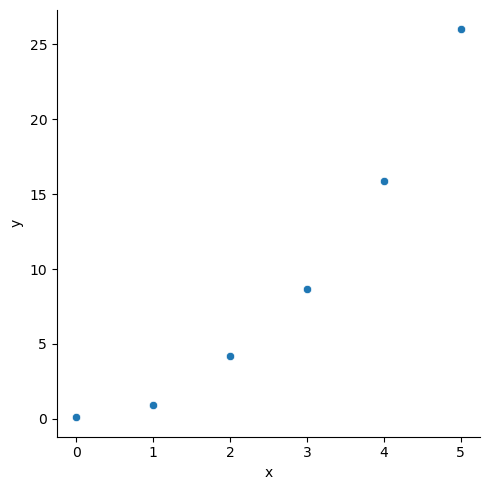

In [22]:
sns.relplot(data = df, x = 'x', y = 'y')
#plt.show()

---

These data look non-linear, like they are following a power law. If that's true, we should get a straight line if we plot the log of the values against one another. Let's see.

In [23]:
df_trans = df.copy()
df_trans['y'] = df['y'].transform(np.log10)
df_trans['x'] = df['x'].transform(np.log10)

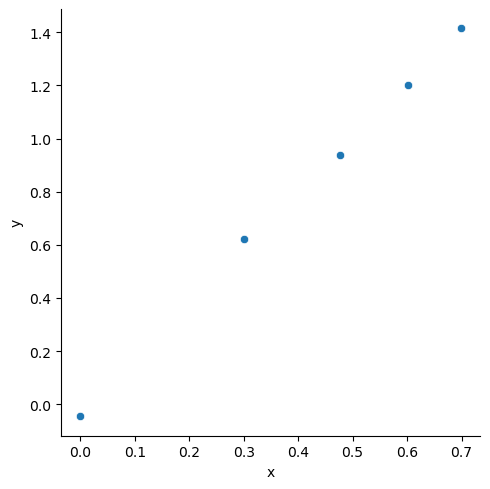

In [24]:
sns.relplot(data = df_trans, x = 'x', y = 'y')
#plt.show()

Sure enough. The slope of the line should tell us the exponent of the power law, and it looks to be about 2. If that's the case, then transforming the original y-values with a square-root function should also produce a straight line.

In [25]:
df_trans = df.copy()
df_trans['y'] = df['y'].transform(np.sqrt)

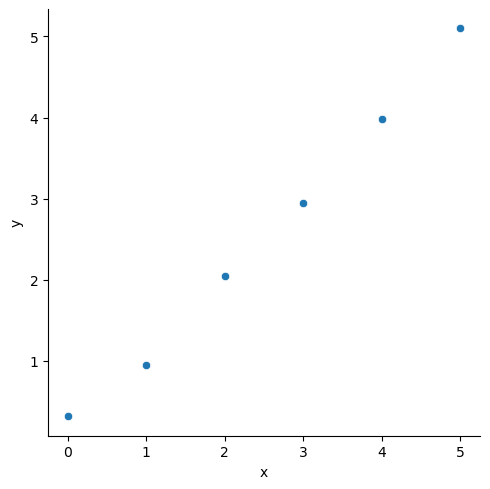

In [26]:
sns.relplot(data = df_trans, x = 'x', y = 'y')
#plt.show()

---

We could also transform our cancer data. In the cell below, create a new data frame in which the numeric values are the natural log of the original values.

In [28]:
bc_logvals = bcd2.copy()
bc_logvals[['thick', 'chrom']] = bcd2[['thick', 'chrom']].transform(np.log)

In [29]:
bc_logvals

id     thick     chrom      class
0    1000025  1.609438  1.098612     benign
1    1002945  1.609438  1.098612     benign
2    1015425  1.098612  1.098612     benign
3    1016277  1.791759  1.098612     benign
4    1017023  1.386294  1.098612     benign
..       ...       ...       ...        ...
694   776715  1.098612  0.000000     benign
695   841769  0.693147  0.000000     benign
696   888820  1.609438  2.079442  malignant
697   897471  1.386294  2.302585  malignant
698   897471  1.386294  2.302585  malignant

[699 rows x 4 columns]

---

### Applying a custom function to data

A great thing about `filter()` (and some other data frame methods) is you can use your own fuctions, not just built in ones.

For `filter()`, the only requirement is that your function

- be able to take a data frame as input
- produce output the same size as the input, or
- produce a single value

Here's a function to "center" data by subtracting the mean from each value. 

In [35]:
def center_data(grp):
    grp_mean = grp.mean(numeric_only = True)
    
    grp = (grp - grp_mean)
    
    return grp

---

In the cell below, use our new function to create new version of our data frame with the mean removed from each group of data. The `.transform()` method works column-by-column, so you don't need to worry about grouping the data.

In [36]:
trans_data = bcd2[['thick', 'chrom']].transform(center_data)

---

Confirm this worked by computing the mean for each column of your transformed data.

In [37]:
trans_data.mean(numeric_only = True)

thick    4.071878e-17
chrom    0.000000e+00
dtype: float64

---

In the cells below, write a function to convert data to z-scores, and use your new function to convert the numeric columns of our cancer data frame.

In [39]:
# my z-score function!
def zed(grp):
    grp_mean = grp.mean(numeric_only = True)
    grp_std = grp.std()
    
    grp = (grp - grp_mean)/grp_std
    
    return grp

In [40]:
# run transform() with my function
trans_data = bcd2[['thick', 'chrom']].transform(zed)

In [41]:
# look at the transformed data
trans_data

thick     chrom
0    0.206942 -0.183305
1    0.206942 -0.183305
2   -0.502864 -0.183305
3    0.561845 -0.183305
4   -0.147961 -0.183305
..        ...       ...
694 -0.502864 -1.002577
695 -0.857766 -1.002577
696  0.206942  1.864876
697 -0.147961  2.684148
698 -0.147961  2.684148

[699 rows x 2 columns]

In [42]:
# see what the means are
trans_data.mean(numeric_only = True)

thick    3.053909e-17
chrom    6.134182e-17
dtype: float64

In [43]:
# see what the ... are
trans_data.std()

thick    1.0
chrom    1.0
dtype: float64

---

#### lambda functions

We can also create transformed copies of the data, where we apply the transformation on a per group basis.

In [ ]:
trans_data = grpd[['thick', 'chrom']].transform(
    lambda col_vals: (col_vals - col_vals.mean()) / col_vals.std()
)

In [ ]:
trans_data.mean()

In [ ]:
trans_data.std()

In [ ]:
bcd['class'].value_counts()

### The `apply()` method

### filtering data with `filter()`

### Combining multiple files

### Duplicate entries # Move to Wrangling II

In [ ]:
bcd.nunique()

In [ ]:
df[df.duplicated(subset = 'patient_id', keep =False)].sort_values('patient_id')

In [ ]:
repeat_patients = df.groupby(by = 'patient_id').size().sort_values(ascending =False)